# Imports


In [57]:
%%capture
pip install spacy

In [58]:
%%capture
pip install ibm_db

In [59]:
import pandas as pd
import numpy as np
import re
import nltk 
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ibm_db
import ibm_db_dbi
import string
from ast import literal_eval
import math

# Database Connection

In [60]:
#Creating variable for DB connection
dsn_hostname = "54a2f15b-5c0f-46df-8954-7e38e612c2bd.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud"
dsn_uid = "qgs98802"  
dsn_pwd = "f20uBnloVxeaSeZK"

dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "bludb"

dsn_port = "32733"
dsn_protocol = "TCPIP"  
 
dsn_security = "SSL"

In [61]:
# Formatting dsn in order to make connection
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};"
    "SECURITY={7};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd, dsn_security)

In [62]:
#Connecting to Database
try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

Connected to database:  bludb as user:  qgs98802 on host:  54a2f15b-5c0f-46df-8954-7e38e612c2bd.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud


In [63]:
pconn = ibm_db_dbi.Connection(conn)

# Base Functions

In [64]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [65]:
def clean_lemma(string_):
    #Takes in lemmas/ngram and cleans them of punctuation marks if there are any
    punctuation = [char for char in string.punctuation]
    string_list = string_.split()
    cleaned_string_list = [char for char in string_list if char not in punctuation]
    cleaned_string = ' '.join(cleaned_string_list)
    return cleaned_string

In [66]:
def get_lemmas(string):
    #Used to pull out the lemmas from each row in the original corpora
    nested_list = literal_eval(string)
    lemma_list = []
    for list_ in nested_list[0]:
        partial_lemma_list = []
        for dict_ in list_:
            supposed_lemma = str(dict_.values())[14:-3]
            supposed_lemma2 = clean_lemma(supposed_lemma)
            lemma = remove_emoji(supposed_lemma2)
            cleaned_lemma = lemma.lower()
            partial_lemma_list.append(cleaned_lemma)
        lemma_list.extend(partial_lemma_list)
        no_space_lemma_list = [lemma for lemma in lemma_list if lemma != '']
    return no_space_lemma_list

In [67]:
def ranking_ngrams(list_, num_ngrams):
    #This creates a dataframe that renders a ranking of the most common lemmas as well as their relative frequencies
    total_ranking = Counter(list_).most_common()
    num_tokens = len(total_ranking)
    most_common_lemmas = total_ranking[0:num_ngrams]
    ngrams = []
    ranking = []
    relative_frequencies = []
    rank = 0
    for entry in most_common_lemmas:
        ngram = entry[0]
        raw_frequency = entry[1]
        relative_frequency = round((raw_frequency/num_tokens)*10000)
        rank +=1
        ngrams.append(ngram)
        ranking.append(rank)
        relative_frequencies.append(relative_frequency)
    df = pd.DataFrame()
    df['Ngrams'] = pd.Series(ngrams)
    df['Ranking'] = pd.Series(ranking)
    df['Relative Frequency (Per 10000 words)']= pd.Series(relative_frequencies)
    return df

In [68]:
def lexical_similarity(df1, df2):
    #This takes all the lemmas of both corpora, and renders a percentage of similarity based on presence of the lemmas. This is a very simple function
    df1_lemma_list = df1['Ngrams'].tolist()
    df2_lemma_list = df2['Ngrams'].tolist()
    percentage_similarity = len(set(df1_lemma_list) & set(df2_lemma_list)) / float(len(set(df1_lemma_list) | set(df2_lemma_list))) * 100
    return round(percentage_similarity,2)

In [69]:
def sentence_parsing_string(string_):
    #replacing any punctuation that could indicate the ending of an idea with a '.' to then parse on the '.'
    new_string = string_.replace('!','.')
    new_string=new_string.replace('?','.')
    new_string= new_string.replace(',','.')
    new_string=new_string.replace(';', '.')
    new_string = new_string.replace('(', '.')
    new_string = new_string.replace(')', '.')
    new_string = new_string.replace(':', '.')
    new_string = new_string.replace("'", ".")
    new_string = new_string.replace('"','.')
    parsed_string = new_string.split('.')
    complete_parsed_string = [phrase for phrase in parsed_string if len(phrase) > 2]
    return complete_parsed_string

In [70]:
def extract_pure_bigrams(post):
    parsed_post = sentence_parsing_string(post)
    nested_bigram_list = []
    for phrase in parsed_post:
        cleaned_phrase = phrase.lower()
        post_bigrams = nltk.ngrams(cleaned_phrase.split(), 2)
        nested_bigram_list.append(list(post_bigrams))
    return nested_bigram_list

In [71]:
def extract_lemma_bigrams_preparsed(post):
    nested_list = literal_eval(post)
    lemma_parsed = []
    for phrase in nested_list[0]:
        lemma_dict = phrase
        lemma_in_phrase = []
        for dict_ in lemma_dict:
            raw_lemma = str(dict_.values())[14:-3]
            lemma = remove_emoji(raw_lemma)
            if lemma == ' ':
                pass
            else:
                lemma_in_phrase.append(lemma.lower())
        ngrams = nltk.ngrams(lemma_in_phrase,2)
        lemma_parsed.append(list(ngrams))
    return lemma_parsed

In [72]:
def get_all_lemma_bigrams(df):
    lemma_bigrams = []
    for post in df['Lemma_Bigrams']:
        post_lemmas = []
        for list_ in post:
            for bigram in list_:
                post_lemmas.append(bigram)
        lemma_bigrams.extend(post_lemmas)
    return lemma_bigrams

In [73]:
def get_all_pure_bigrams(df):
    pure_bigrams = []
    for post in df['Pure_Bigrams']:
        post_lemmas = []
        for list_ in post:
            for bigram in list_:
                post_lemmas.append(bigram)
        pure_bigrams.extend(post_lemmas)
    return pure_bigrams

# Data Preparation

In [74]:
artificial_dialect1_unigram = pd.read_csv('artificial_dialect1_unigrams.csv')
artificial_dialect2_unigram = pd.read_csv('artificial_dialect2_unigrams.csv')

artificial_dialect1_bigram = pd.read_csv('artificial_dialect1_lemmab.csv')
artificial_dialect2_bigram = pd.read_csv('artificial_dialect2_lemmab.csv')

artificial_dialect1_pure = pd.read_csv('artificial_dialect1_pure.csv')
artificial_dialect2_pure = pd.read_csv('artificial_dialect2_pure.csv')

In [75]:
# Collect all the lemma in the dataset
total_reddit_df = pd.read_csv('../PycharmProjects/hispanic_politic_analysis/reddit_ling_data.csv')
total_reddit_df.rename(columns={'Lemmatization':'LEMMATIZATION'}, inplace=True)
total_youtube_corpus = 'Select INDEX, PARSED_CONTENT, LEMMATIZATION from youtube_ling'
total_youtube_df = pd.read_sql(total_youtube_corpus, pconn)
total_twitter_df = pd.read_csv('../PycharmProjects/hispanic_politic_analysis/twitter_ling_data.csv')
total_twitter_df.rename(columns={'Lemmatization':'LEMMATIZATION'}, inplace=True)

In [76]:
#Recreating the twitter data set with the information that we need
twitter_query = 'Select tweet_id, content, country from twitter_data'
twitter_incomplete_df = pd.read_sql(twitter_query, pconn)
twitter_lemmas =total_twitter_df['LEMMATIZATION']
twitter_df = pd.concat([twitter_incomplete_df, twitter_lemmas], axis=1)

#Getting the bigrams from the Twitter data
twitter_df['Parsed_Content'] = twitter_df['CONTENT'].apply(sentence_parsing_string)
twitter_df['Lemma_Bigrams'] = twitter_df['LEMMATIZATION'].apply(extract_lemma_bigrams_preparsed)
twitter_df['Pure_Bigrams'] = twitter_df['CONTENT'].apply(extract_pure_bigrams)
twitter_df['Lemmas'] = twitter_df['LEMMATIZATION'].apply(get_lemmas)

#Getting the bigrams from the reddit data
reddit_query = 'Select country from reddit_data'
reddit_country = pd.read_sql(reddit_query, pconn)
total_reddit_df['Pure_Bigrams'] = total_reddit_df['PARSED_CONTENT'].apply(extract_pure_bigrams)
total_reddit_df['Lemma_Bigrams'] = total_reddit_df['LEMMATIZATION'].apply(extract_lemma_bigrams_preparsed)
total_reddit_df['Lemmas'] = total_reddit_df['LEMMATIZATION'].apply(get_lemmas)
reddit_df = pd.concat([total_reddit_df, reddit_country], axis=1)

#Getting the bigrams from the youtube data
youtube_query = 'Select country from youtube_data'
youtube_country = pd.read_sql(youtube_query, pconn)
total_youtube_df['Pure_Bigrams'] = total_youtube_df['PARSED_CONTENT'].apply(extract_pure_bigrams)
total_youtube_df['Lemma_Bigrams'] = total_youtube_df['LEMMATIZATION'].apply(extract_lemma_bigrams_preparsed)
total_youtube_df['Lemmas'] = total_youtube_df['LEMMATIZATION'].apply(get_lemmas)
youtube_df = pd.concat([total_youtube_df, youtube_country], axis=1)

In [77]:
complete_df = pd.concat([youtube_df, reddit_df, twitter_df], axis=0, ignore_index=True)
complete_df = complete_df[['COUNTRY', 'Lemmas', 'Pure_Bigrams', 'Lemma_Bigrams']]


In [78]:
artificial_dialect1_bigram['Ngrams'] = artificial_dialect1_bigram['Ngrams'].apply(literal_eval)
artificial_dialect2_bigram['Ngrams'] = artificial_dialect2_bigram['Ngrams'].apply(literal_eval)

artificial_dialect1_pure['Ngrams'] = artificial_dialect1_pure['Ngrams'].apply(literal_eval)
artificial_dialect2_pure['Ngrams'] = artificial_dialect2_pure['Ngrams'].apply(literal_eval)

# Sampling

In a previous notebook I worked out and compared two distinct artificial dialects. The dialects were two separate attempts at creating a dialectually neutral dialect. In the aforementioned notebook, their lexical compositions were compared to various natural dialects. They seemed to render distinct scores of lexical similarity though this will be a true test of how distinct they are.

In this section, I will be testing the performance of the artificial dialect in a uni-dialectal context. In other words, random sampling will be used to create a sample of posts from each country from the dataset a thousand times. I will then extract the most common ngrams from the samples as a representation of the dialect being tested. After finding the most common ngrams, each sample will be tested for their lexical similarity with the artificial dialects. The scores will be stored and represented as a histogram to get a visual comparison of how the dialects perform with regard to lexical similarity.

Once the histograms are created and we have the necessary distribution statistics, hypothesis testing will be used to evaluate if the  distributions of lexical similarity are truly distinct or not. The test statistic in use will the difference of their means with the initial assumption, null hypothesis, being their the difference is zero. The alternative hypothesis, or what will be tested, will be that the differences in means will not be zero. I've chosen an alpha level of 5% and therefore the beginning of the critical range will lie at a z-scores of -1.96 and 1.96. If the z-scores lie within the critical range, more than 1.96 or less than 1.96, then we can be sure with at least 95% certainty that the distribution are distinct from each other. 

#### Functions used for this section

In [79]:
def random_index(size_index, size_data):
    #provides randomly selected indexes to collect from data
    index_set = set()
    while len(index_set) != size_index:
        random_variable = np.random.randint(size_data)
        index_set.add(random_variable) 
    return index_set

In [80]:
def random_sample_acc(df, country, column, sample_size):
    country_df = df[df['COUNTRY']==country]
    posts= country_df[column].tolist()
    index= random_index(sample_size, len(posts))
    sample_ngrams = []
    for index in index:
        sample_ngram=posts[index]
        sample_ngrams.append(sample_ngram)
    return sample_ngrams

In [81]:
def extract_bigrams(list_):
    ngrams=[]
    for post in list_:
        for phrase in post:
            for bigram in phrase:
                word_1 = str(bigram[0])
                word_2 = str(bigram[1])
                new_bigram = (f'{word_1}', f'{word_2}')
                ngrams.append(new_bigram)
    return ngrams

In [82]:
def extract_unigrams(list_):
    ngrams=[]
    for post in list_:
        for word in post:
            ngrams.append(word)
    return ngrams

In [83]:
def acc_sample_unigram_ranking(country):
    country_sample = extract_unigrams(random_sample_acc(complete_df, country, 'Lemmas', 5000))
    unigram_ranking = ranking_ngrams(country_sample, 500)
    return unigram_ranking

In [84]:
def acc_sample_bigram_ranking(country, column):
    country_sample = extract_bigrams(random_sample_acc(complete_df, country, column, 5000))
    bigram_ranking = ranking_ngrams(country_sample, 100)
    return bigram_ranking

In [85]:
def get_z_score(values1, values2):         
    mean1= np.mean(np.array(values1))
    mean2= np.mean(np.array(values2))
    
    std1= np.std(np.array(values1))
    std2= np.std(np.array(values2))
    
    numerator = mean1-mean2
    denominator = math.sqrt((std1**2/len(values1))+(std2**2/len(values2)))
    z_score = numerator/denominator
    return z_score

In [86]:
def unigram_similarity_sampling_means(country):
    artificial_dialect1_scores_uni = []
    artificial_dialect2_scores_uni= []
    percentage_list = [10, 25, 50, 75, 100]
    for i in range (1000):
        unigram_sample_ranking = acc_sample_unigram_ranking(country) #look at this function to be restructured
        percentages_similarity_dialect_1_uni = []
        percentages_similarity_dialect_2_uni = []
        for percentage in percentage_list:
            percentile = int(500 * (percentage/100))
            artificial_1_similarity_uni = lexical_similarity(unigram_sample_ranking[0:percentile],
                                                             artificial_dialect1_unigram[0:percentile])
            artificial_2_similarity_uni = lexical_similarity(unigram_sample_ranking[0:percentile],
                                                             artificial_dialect2_unigram[0:percentile])
            percentages_similarity_dialect_1_uni.append(artificial_1_similarity_uni)
            percentages_similarity_dialect_2_uni.append(artificial_2_similarity_uni)
        mean1 = np.mean(np.array(percentages_similarity_dialect_1_uni))
        mean2 = np.mean(np.array(percentages_similarity_dialect_2_uni))
        artificial_dialect1_scores_uni.append(mean1)
        artificial_dialect2_scores_uni.append(mean2)
    return [artificial_dialect1_scores_uni, artificial_dialect2_scores_uni]

In [87]:
def bigram_similarity_sampling_means(country, column, artificial_dialect1, artificial_dialect2):
    artificial_dialect1_scores_bi = []
    artificial_dialect2_scores_bi= []
    percentage_list = [10, 25, 50, 75, 100]
    for i in range (1000):
        bigram_sample_ranking = acc_sample_bigram_ranking(country, column)
        percentages_similarity_dialect_1_bi = []
        percentages_similarity_dialect_2_bi = []
        for percentage in percentage_list:
            percentile = percentage
            artificial_1_similarity_bi = lexical_similarity(bigram_sample_ranking[0:percentile],
                                                         artificial_dialect1[0:percentile])
            artificial_2_similarity_bi = lexical_similarity(bigram_sample_ranking[0:percentile],
                                                         artificial_dialect2[0:percentile])
            percentages_similarity_dialect_1_bi.append(artificial_1_similarity_bi)
            percentages_similarity_dialect_2_bi.append(artificial_2_similarity_bi)
        mean1_bi = np.mean(np.array(percentages_similarity_dialect_1_bi))
        mean2_bi = np.mean(np.array(percentages_similarity_dialect_2_bi))
        artificial_dialect1_scores_bi.append(mean1_bi)
        artificial_dialect2_scores_bi.append(mean2_bi)
    return [artificial_dialect1_scores_bi, artificial_dialect2_scores_bi]

# Argentina Test

<AxesSubplot:title={'center':'Pure Bigram Similarity, Argentina'}, ylabel='Density'>

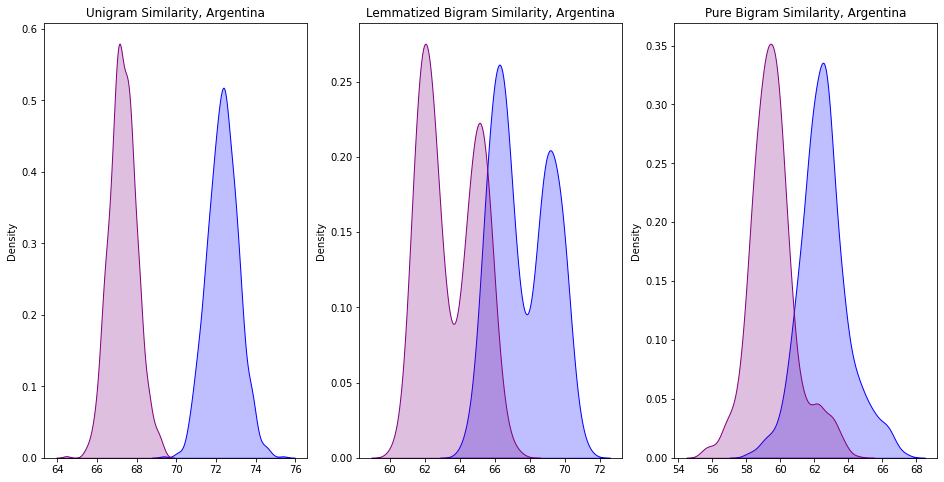

In [88]:
fig, axs = plt.subplots(1,3, figsize=(16,8))

argentina_uni_means= unigram_similarity_sampling_means('Argentina')
axs[0].set_title('Unigram Similarity, Argentina')
sns.kdeplot(argentina_uni_means[0], ax=axs[0], color='blue', fill=True)
sns.kdeplot(argentina_uni_means[1], ax=axs[0], color='purple', fill=True)

argentina_bi_lemma_means = bigram_similarity_sampling_means('Argentina', 'Lemma_Bigrams', artificial_dialect1_bigram,
                                                           artificial_dialect2_bigram)
axs[1].set_title('Lemmatized Bigram Similarity, Argentina')
sns.kdeplot(argentina_bi_lemma_means[0], ax=axs[1], color='blue', fill=True)
sns.kdeplot(argentina_bi_lemma_means[1], ax=axs[1], color='purple', fill=True)

argentina_pure_means = bigram_similarity_sampling_means('Argentina', 'Pure_Bigrams', artificial_dialect1_pure,
                                                       artificial_dialect2_pure)
axs[2].set_title('Pure Bigram Similarity, Argentina')
sns.kdeplot(argentina_pure_means[0], ax=axs[2], color='blue', fill=True)
sns.kdeplot(argentina_pure_means[1], ax=axs[2], color='purple', fill=True)

In [89]:
argentina_unigram_score = get_z_score(argentina_uni_means[0], argentina_uni_means[1])
argentina_bi_lemma_score = get_z_score(argentina_bi_lemma_means[0], argentina_bi_lemma_means[1])
argentina_pure_score = get_z_score(argentina_pure_means[0], argentina_pure_means[1])

print(f'''The z-score of the Unigram similarity sampling distribution is {round(argentina_unigram_score, 2)}
The z-score for the Lemmatized Bigram similarity samping distribution is {round(argentina_bi_lemma_score, 2)}
The z-score for the Pure Bigram similarity sampling distribution is  {round (argentina_pure_score, 2)}
These are within the critical range and therefore we can be quite certain that the distributions are distinct.''')

The z-score of the Unigram similarity sampling distribution is 153.04
The z-score for the Lemmatized Bigram similarity samping distribution is 55.81
The z-score for the Pure Bigram similarity sampling distribution is  48.1
These are within the critical range and therefore we can be quite certain that the distributions are distinct.


# Mexico Test

<AxesSubplot:title={'center':'Pure Bigram Similarity, Mexico'}, ylabel='Density'>

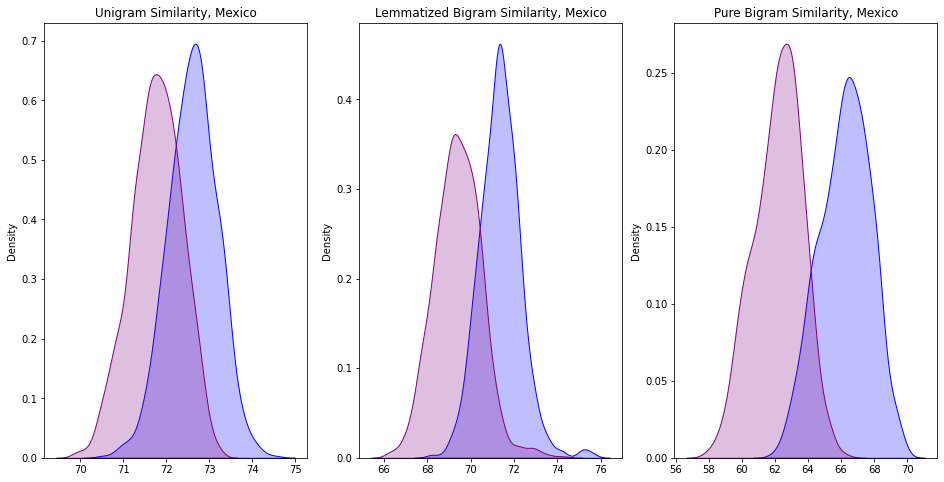

In [90]:
fig, axs = plt.subplots(1,3, figsize=(16,8))

mexico_uni_means= unigram_similarity_sampling_means('Mexico')
axs[0].set_title('Unigram Similarity, Mexico')
sns.kdeplot(mexico_uni_means[0], ax=axs[0], color='blue', fill=True)
sns.kdeplot(mexico_uni_means[1], ax=axs[0], color='purple', fill=True)

mexico_bi_lemma_means = bigram_similarity_sampling_means('Mexico', 'Lemma_Bigrams', artificial_dialect1_bigram,
                                                           artificial_dialect2_bigram)
axs[1].set_title('Lemmatized Bigram Similarity, Mexico')
sns.kdeplot(mexico_bi_lemma_means[0], ax=axs[1], color='blue', fill=True)
sns.kdeplot(mexico_bi_lemma_means[1], ax=axs[1], color='purple', fill=True)

mexico_pure_means = bigram_similarity_sampling_means('Mexico', 'Pure_Bigrams', artificial_dialect1_pure,
                                                       artificial_dialect2_pure)
axs[2].set_title('Pure Bigram Similarity, Mexico')
sns.kdeplot(mexico_pure_means[0], ax=axs[2], color='blue', fill=True)
sns.kdeplot(mexico_pure_means[1], ax=axs[2], color='purple', fill=True)

In [91]:
mexico_unigram_score = get_z_score(mexico_uni_means[0], mexico_uni_means[1])
mexico_bi_lemma_score = get_z_score(mexico_bi_lemma_means[0], mexico_bi_lemma_means[1])
mexico_pure_score = get_z_score(mexico_pure_means[0], mexico_pure_means[1])

print(f'''The z-score of the Unigram similarity sampling distribution is {round(mexico_unigram_score, 2)}
The z-score for the Lemmatized Bigram similarity samping distribution is {round(mexico_bi_lemma_score, 2)}
The z-score for the Pure Bigram similarity sampling distribution is  {round (mexico_pure_score, 2)}
These are within the critical range and therefore we can be quite certain that the distributions are distinct.''')

The z-score of the Unigram similarity sampling distribution is 32.62
The z-score for the Lemmatized Bigram similarity samping distribution is 42.17
The z-score for the Pure Bigram similarity sampling distribution is  60.73
These are within the critical range and therefore we can be quite certain that the distributions are distinct.


# Colombia Test

<AxesSubplot:title={'center':'Pure Bigram Similarity, Colombia'}, ylabel='Density'>

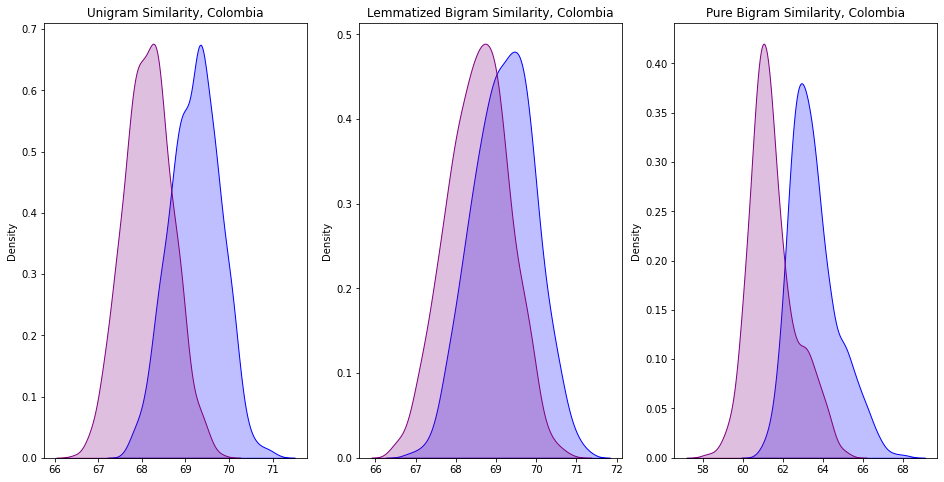

In [92]:
fig, axs = plt.subplots(1,3, figsize=(16,8))

colombia_uni_means= unigram_similarity_sampling_means('Colombia')
axs[0].set_title('Unigram Similarity, Colombia')
sns.kdeplot(colombia_uni_means[0], ax=axs[0], color='blue', fill=True)
sns.kdeplot(colombia_uni_means[1], ax=axs[0], color='purple', fill=True)

colombia_bi_lemma_means = bigram_similarity_sampling_means('Colombia', 'Lemma_Bigrams', artificial_dialect1_bigram,
                                                           artificial_dialect2_bigram)
axs[1].set_title('Lemmatized Bigram Similarity, Colombia')
sns.kdeplot(colombia_bi_lemma_means[0], ax=axs[1], color='blue', fill=True)
sns.kdeplot(colombia_bi_lemma_means[1], ax=axs[1], color='purple', fill=True)

colombia_pure_means = bigram_similarity_sampling_means('Colombia', 'Pure_Bigrams', artificial_dialect1_pure,
                                                       artificial_dialect2_pure)
axs[2].set_title('Pure Bigram Similarity, Colombia')
sns.kdeplot(colombia_pure_means[0], ax=axs[2], color='blue', fill=True)
sns.kdeplot(colombia_pure_means[1], ax=axs[2], color='purple', fill=True)

In [93]:
colombia_unigram_score = get_z_score(colombia_uni_means[0], colombia_uni_means[1])
colombia_bi_lemma_score = get_z_score(colombia_bi_lemma_means[0], colombia_bi_lemma_means[1])
colombia_pure_score = get_z_score(colombia_pure_means[0], colombia_pure_means[1])

print(f'''The z-score of the Unigram similarity sampling distribution is {round(colombia_unigram_score, 2)}
The z-score for the Lemmatized Bigram similarity samping distribution is {round(colombia_bi_lemma_score, 2)}
The z-score for the Pure Bigram similarity sampling distribution is  {round (colombia_pure_score, 2)}
These are within the critical range and therefore we can be quite certain that the distributions are distinct.''')

The z-score of the Unigram similarity sampling distribution is 42.98
The z-score for the Lemmatized Bigram similarity samping distribution is 18.61
The z-score for the Pure Bigram similarity sampling distribution is  38.96
These are within the critical range and therefore we can be quite certain that the distributions are distinct.


# Spain Test

<AxesSubplot:title={'center':'Pure Bigram Similarity, Spain'}, ylabel='Density'>

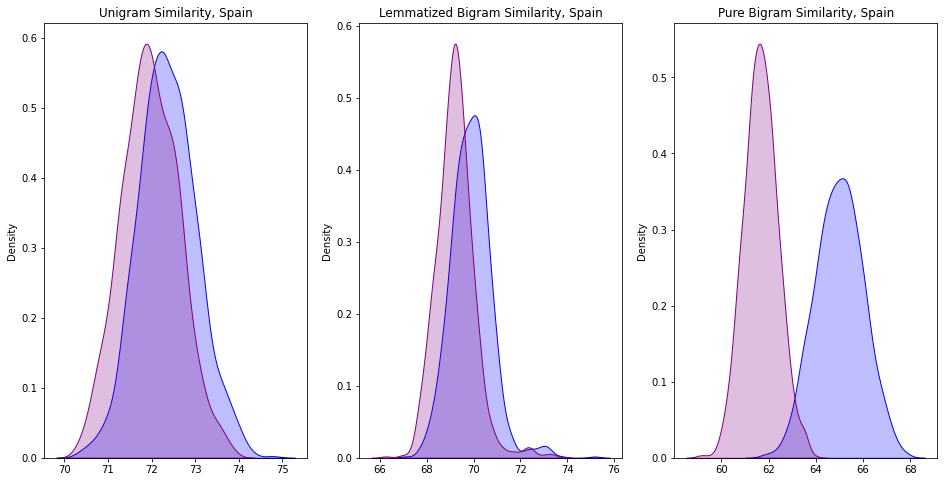

In [94]:
fig, axs = plt.subplots(1,3, figsize=(16,8))

spain_uni_means= unigram_similarity_sampling_means('Spain')
axs[0].set_title('Unigram Similarity, Spain')
sns.kdeplot(spain_uni_means[0], ax=axs[0], color='blue', fill=True)
sns.kdeplot(spain_uni_means[1], ax=axs[0], color='purple', fill=True)

spain_bi_lemma_means = bigram_similarity_sampling_means('Spain', 'Lemma_Bigrams', artificial_dialect1_bigram,
                                                           artificial_dialect2_bigram)
axs[1].set_title('Lemmatized Bigram Similarity, Spain')
sns.kdeplot(spain_bi_lemma_means[0], ax=axs[1], color='blue', fill=True)
sns.kdeplot(spain_bi_lemma_means[1], ax=axs[1], color='purple', fill=True)

spain_pure_means = bigram_similarity_sampling_means('Spain', 'Pure_Bigrams', artificial_dialect1_pure,
                                                       artificial_dialect2_pure)
axs[2].set_title('Pure Bigram Similarity, Spain')
sns.kdeplot(spain_pure_means[0], ax=axs[2], color='blue', fill=True)
sns.kdeplot(spain_pure_means[1], ax=axs[2], color='purple', fill=True)

In [95]:
spain_unigram_score = get_z_score(spain_uni_means[0], spain_uni_means[1])
spain_bi_lemma_score = get_z_score(spain_bi_lemma_means[0], spain_bi_lemma_means[1])
spain_pure_score = get_z_score(spain_pure_means[0], spain_pure_means[1])

print(f'''The z-score of the Unigram similarity sampling distribution is {round(spain_unigram_score, 2)}
The z-score for the Lemmatized Bigram similarity samping distribution is {round(spain_bi_lemma_score, 2)}
The z-score for the Pure Bigram similarity sampling distribution is  {round (spain_pure_score, 2)}
These are within the critical range and therefore we can be quite certain that the distributions are distinct.''')

The z-score of the Unigram similarity sampling distribution is 13.33
The z-score for the Lemmatized Bigram similarity samping distribution is 17.44
The z-score for the Pure Bigram similarity sampling distribution is  84.51
These are within the critical range and therefore we can be quite certain that the distributions are distinct.


# Peru Test

<AxesSubplot:title={'center':'Pure Bigram Similarity, Peru'}, ylabel='Density'>

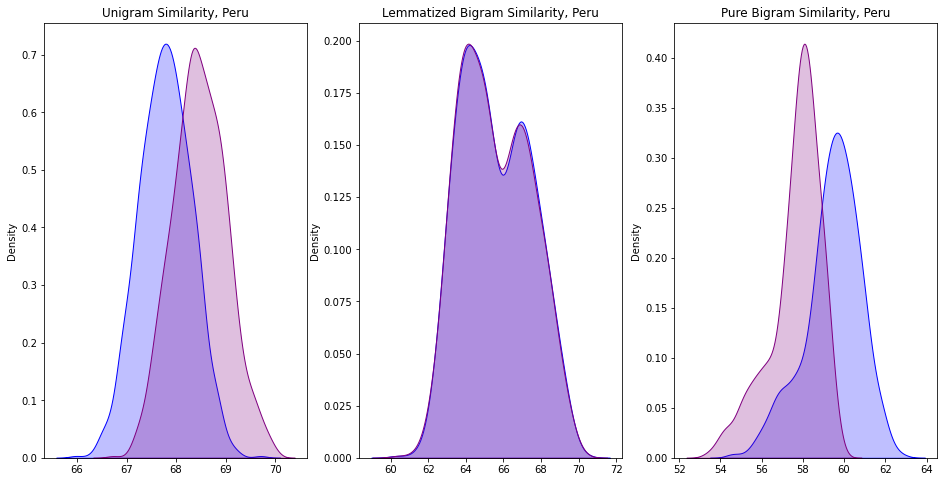

In [96]:
fig, axs = plt.subplots(1,3, figsize=(16,8))

peru_uni_means= unigram_similarity_sampling_means('Peru')
axs[0].set_title('Unigram Similarity, Peru')
sns.kdeplot(peru_uni_means[0], ax=axs[0], color='blue', fill=True)
sns.kdeplot(peru_uni_means[1], ax=axs[0], color='purple', fill=True)

peru_bi_lemma_means = bigram_similarity_sampling_means('Peru', 'Lemma_Bigrams', artificial_dialect1_bigram,
                                                           artificial_dialect2_bigram)
axs[1].set_title('Lemmatized Bigram Similarity, Peru')
sns.kdeplot(peru_bi_lemma_means[0], ax=axs[1], color='blue', fill=True)
sns.kdeplot(peru_bi_lemma_means[1], ax=axs[1], color='purple', fill=True)

peru_pure_means = bigram_similarity_sampling_means('Peru', 'Pure_Bigrams', artificial_dialect1_pure,
                                                       artificial_dialect2_pure)
axs[2].set_title('Pure Bigram Similarity, Peru')
sns.kdeplot(peru_pure_means[0], ax=axs[2], color='blue', fill=True)
sns.kdeplot(peru_pure_means[1], ax=axs[2], color='purple', fill=True)

In [102]:
peru_unigram_score = get_z_score(peru_uni_means[0], peru_uni_means[1])
peru_bi_lemma_score = get_z_score(peru_bi_lemma_means[0], peru_bi_lemma_means[1])
peru_pure_score = get_z_score(peru_pure_means[0], peru_pure_means[1])

print(f'''The z-score of the Unigram similarity sampling distribution is {round(peru_unigram_score, 2)}
The z-score for the Lemmatized Bigram similarity samping distribution is {round(peru_bi_lemma_score, 2)}
The z-score for the Pure Bigram similarity sampling distribution is  {round (peru_pure_score, 2)}
All besides the Lemmatized Bigram similarity sampling distribution are within the critical range and therefore we can be quite certain that the distributions, besides that one, are distinct.''')

The z-score of the Unigram similarity sampling distribution is -28.87
The z-score for the Lemmatized Bigram similarity samping distribution is 0.25
The z-score for the Pure Bigram similarity sampling distribution is  30.61
All besides the Lemmatized Bigram similarity sampling distribution are within the critical range and therefore we can be quite certain that the distributions, besides that one, are distinct.


# Chile Test

<AxesSubplot:title={'center':'Pure Bigram Similarity, Chile'}, ylabel='Density'>

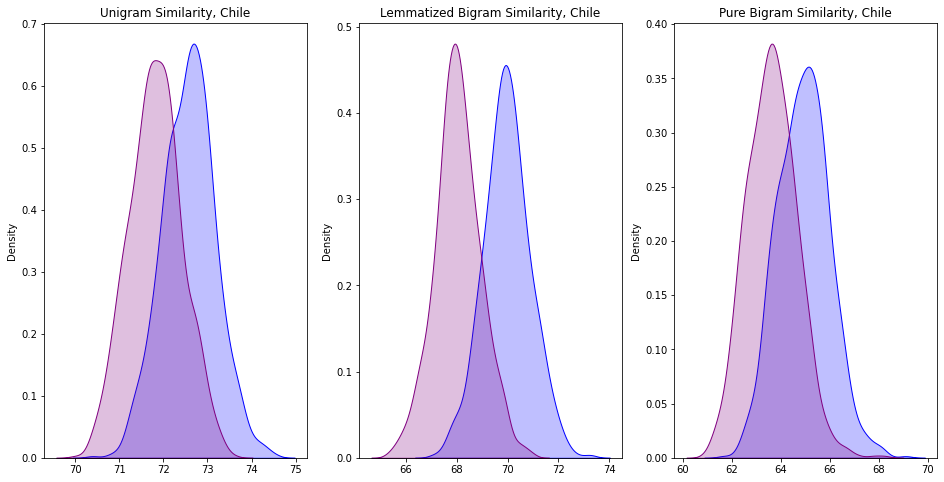

In [98]:
fig, axs = plt.subplots(1,3, figsize=(16,8) )

chile_uni_means= unigram_similarity_sampling_means('Chile')
axs[0].set_title('Unigram Similarity, Chile')
sns.kdeplot(chile_uni_means[0], ax=axs[0], color='blue', fill=True)
sns.kdeplot(chile_uni_means[1], ax=axs[0], color='purple', fill=True)

chile_bi_lemma_means = bigram_similarity_sampling_means('Chile', 'Lemma_Bigrams', artificial_dialect1_bigram,
                                                           artificial_dialect2_bigram)
axs[1].set_title('Lemmatized Bigram Similarity, Chile')
sns.kdeplot(chile_bi_lemma_means[0], ax=axs[1], color='blue', fill=True)
sns.kdeplot(chile_bi_lemma_means[1], ax=axs[1], color='purple', fill=True)

chile_pure_means = bigram_similarity_sampling_means('Chile', 'Pure_Bigrams', artificial_dialect1_pure,
                                                       artificial_dialect2_pure)
axs[2].set_title('Pure Bigram Similarity, Chile')
sns.kdeplot(chile_pure_means[0], ax=axs[2], color='blue', fill=True)
sns.kdeplot(chile_pure_means[1], ax=axs[2], color='purple', fill=True)

In [99]:
chile_unigram_score = get_z_score(chile_uni_means[0], chile_uni_means[1])
chile_bi_lemma_score = get_z_score(chile_bi_lemma_means[0], chile_bi_lemma_means[1])
chile_pure_score = get_z_score(chile_pure_means[0], chile_pure_means[1])

print(f'''The z-score of the Unigram similarity sampling distribution is {round(chile_unigram_score, 2)}
The z-score for the Lemmatized Bigram similarity samping distribution is {round(chile_bi_lemma_score, 2)}
The z-score for the Pure Bigram similarity sampling distribution is  {round (chile_pure_score, 2)}
These are within the critical range and therefore we can be quite certain that the distributions are distinct.''')

The z-score of the Unigram similarity sampling distribution is 28.23
The z-score for the Lemmatized Bigram similarity samping distribution is 46.99
The z-score for the Pure Bigram similarity sampling distribution is  27.72
These are within the critical range and therefore we can be quite certain that the distributions are distinct.


# Ecuador Test

<AxesSubplot:title={'center':'Pure Bigram Similarity, Ecuador'}, ylabel='Density'>

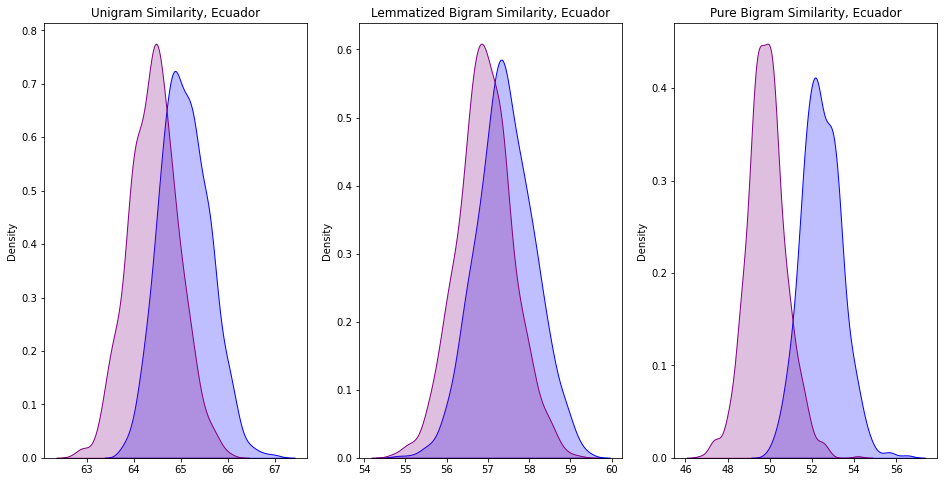

In [100]:
fig, axs = plt.subplots(1,3, figsize=(16,8))

ecuador_uni_means= unigram_similarity_sampling_means('Ecuador')
axs[0].set_title('Unigram Similarity, Ecuador')
sns.kdeplot(ecuador_uni_means[0], ax=axs[0], color='blue', fill=True)
sns.kdeplot(ecuador_uni_means[1], ax=axs[0], color='purple', fill=True)

ecuador_bi_lemma_means = bigram_similarity_sampling_means('Ecuador', 'Lemma_Bigrams', artificial_dialect1_bigram,
                                                           artificial_dialect2_bigram)
axs[1].set_title('Lemmatized Bigram Similarity, Ecuador')
sns.kdeplot(ecuador_bi_lemma_means[0], ax=axs[1], color='blue', fill=True)
sns.kdeplot(ecuador_bi_lemma_means[1], ax=axs[1], color='purple', fill=True)

ecuador_pure_means = bigram_similarity_sampling_means('Ecuador', 'Pure_Bigrams', artificial_dialect1_pure,
                                                       artificial_dialect2_pure)
axs[2].set_title('Pure Bigram Similarity, Ecuador')
sns.kdeplot(ecuador_pure_means[0], ax=axs[2], color='blue', fill=True)
sns.kdeplot(ecuador_pure_means[1], ax=axs[2], color='purple', fill=True)

In [101]:
ecuador_unigram_score = get_z_score(ecuador_uni_means[0], ecuador_uni_means[1])
ecuador_bi_lemma_score = get_z_score(ecuador_bi_lemma_means[0], ecuador_bi_lemma_means[1])
ecuador_pure_score = get_z_score(ecuador_pure_means[0], ecuador_pure_means[1])

print(f'''The z-score of the Unigram similarity sampling distribution is {round(ecuador_unigram_score, 2)}
The z-score for the Lemmatized Bigram similarity samping distribution is {round(ecuador_bi_lemma_score, 2)}
The z-score for the Pure Bigram similarity sampling distribution is  {round (ecuador_pure_score, 2)}
These are within the critical range and therefore we can be quite certain that the distributions are distinct.''')

The z-score of the Unigram similarity sampling distribution is 28.25
The z-score for the Lemmatized Bigram similarity samping distribution is 15.67
The z-score for the Pure Bigram similarity sampling distribution is  62.49
These are within the critical range and therefore we can be quite certain that the distributions are distinct.
